In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import shap
import os

/home/uiif/anaconda3/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not os.path.exists("data.pkl"):
    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    secondary_mushroom = fetch_ucirepo(id=848)

    df = secondary_mushroom.data.features
    df = df.assign(target=secondary_mushroom.data.targets)
    with open("data.pkl", "wb") as f:
        pickle.dump(df, f)
else:
    with open("data.pkl", "rb") as f:
        df = pickle.load(f)
df["target"] = (df["target"] == "p").astype(int)

# Оценка данных

## Обработка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

In [4]:
real_features = ["cap-diameter", "stem-height", "stem-width"]
nullable_features = ["stem-root", "veil-type", "veil-color", "spore-print-color"]
cat_features = list(
    set(df.columns) - set(real_features) - set(["target"]) - set(nullable_features)
)


In [5]:
train, test = train_test_split(df, test_size=0.2)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)


### Label Encoder

In [6]:
class OrderedLabelEncoder(LabelEncoder):
    def fit(self, X, y):
        X = super(OrderedLabelEncoder, self).fit_transform(X)
        
        classes = np.unique(X, return_counts=True)
        
        probs = [y[X == cl].sum()/cl_count for cl, cl_count in zip(*classes)]
        self.args = np.argsort(probs)
        return self
    
    def transform(self, X):
        X = super(OrderedLabelEncoder, self).transform(X)
        return self.args[X]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [7]:
ole = OrderedLabelEncoder()
le = LabelEncoder()


ordere_lable_encoded_cat_features = []
lable_encoded_cat_features = []
for feat in cat_features:
    train[feat + "_OLE"] = ole.fit_transform(train[feat], train['target'])
    train[feat + "_LE"] = le.fit_transform(train[feat])

    test[feat + "_OLE"] = ole.transform(test[feat])
    test[feat + "_LE"] = le.transform(test[feat])
    lable_encoded_cat_features.append(feat + "_LE")
    ordere_lable_encoded_cat_features.append(feat + "_OLE")


In [8]:
train[lable_encoded_cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48855 entries, 0 to 48854
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   cap-surface_LE           48855 non-null  int64
 1   habitat_LE               48855 non-null  int64
 2   has-ring_LE              48855 non-null  int64
 3   stem-surface_LE          48855 non-null  int64
 4   does-bruise-or-bleed_LE  48855 non-null  int64
 5   ring-type_LE             48855 non-null  int64
 6   stem-color_LE            48855 non-null  int64
 7   cap-color_LE             48855 non-null  int64
 8   cap-shape_LE             48855 non-null  int64
 9   gill-color_LE            48855 non-null  int64
 10  gill-attachment_LE       48855 non-null  int64
 11  gill-spacing_LE          48855 non-null  int64
 12  season_LE                48855 non-null  int64
dtypes: int64(13)
memory usage: 4.8 MB


<Axes: >

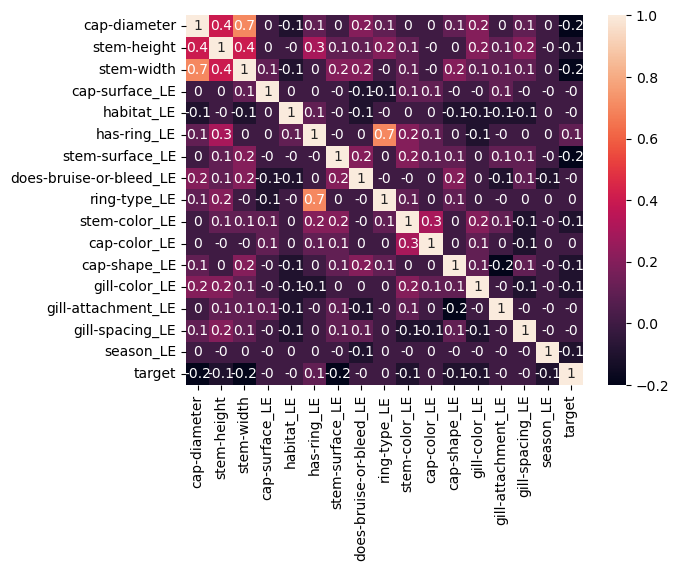

In [9]:
sns.heatmap(
    np.round(train[real_features + lable_encoded_cat_features + ["target"]].corr(), 1),
    annot=True,
)

### One Hot

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
train["gill-spacing"].unique()

array(['c', nan, 'f', 'd'], dtype=object)

In [12]:
ohe = OneHotEncoder(sparse_output=False, drop="first")
cols = ohe.fit_transform(train[cat_features])
ohe_columns_name = list(ohe.get_feature_names_out(cat_features))
train = pd.concat([train, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1)

In [13]:
pd.concat([train, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1).shape[0] - train.shape[0]

0

In [14]:
cols = ohe.transform(test[cat_features])
test = pd.concat([test, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1)


<Axes: >

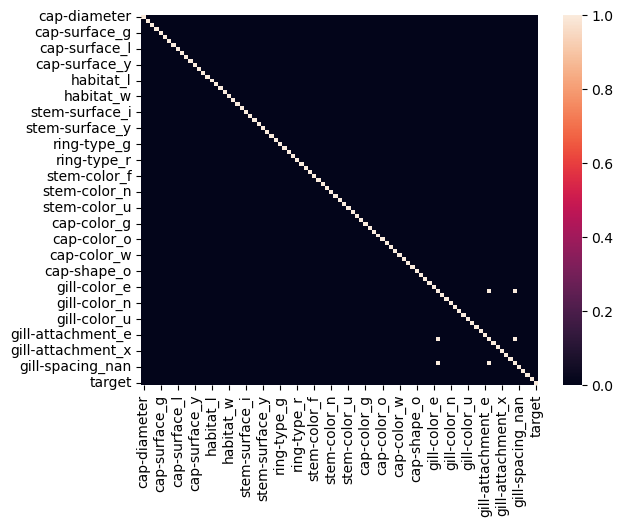

In [15]:
sns.heatmap(
    train[real_features + ohe_columns_name + ["target"]].corr() > 0.75
)


In [16]:
# corrs = train[real_features + ohe_columns_name + ["target"]].corr()
# corrs_without_diag = (corrs > 0.75) - np.eye(
#     train[real_features + ohe_columns_name + ["target"]].shape[1]
# )
# inds = corrs_without_diag[(corrs_without_diag > 0).any()].index
# corrs.loc[inds, inds]

# ohe_columns_name.remove(inds[1])
# ohe_columns_name.remove(inds[2])

<Axes: >

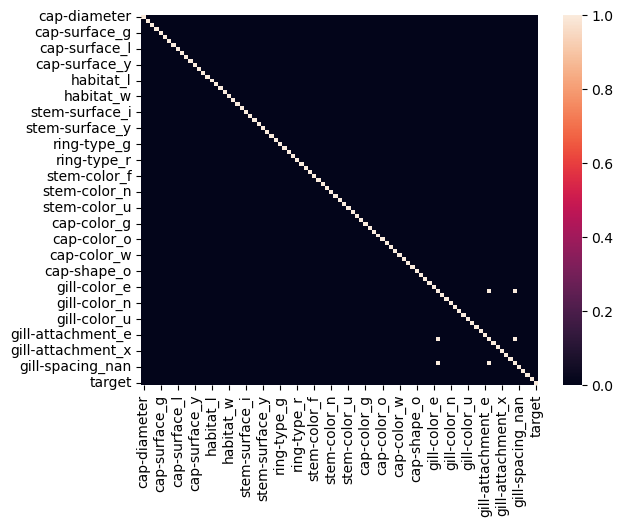

In [17]:
sns.heatmap(train[real_features + ohe_columns_name + ["target"]].corr() > 0.75)

### Feature batched

In [18]:
train[real_features[0]]

0         3.46
1         5.75
2         1.16
3         2.58
4         3.43
         ...  
48850     1.98
48851    11.81
48852     1.69
48853     4.02
48854     3.12
Name: cap-diameter, Length: 48855, dtype: float64

In [19]:
one_rule_features = []
for feat in real_features:
    train[feat + "_mean"] = train[feat] > train[feat].mean()
    test[feat + "_mean"] = test[feat] > train[feat].mean()
    one_rule_features.append(feat + "_mean")
    quants = [0.25, 0.5, 0.75]
    _, bins = pd.qcut(train[feat], quants, retbins=True)
    for b, q in zip(bins, quants):
        train[feat + f"q_{q}"] = train[feat] > b
        test[feat + f"q_{q}"] = test[feat] > b
        one_rule_features.append(feat + f"q_{q}")

## Feature selection

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [21]:
default_le_features = real_features + lable_encoded_cat_features
default_ohe_features = real_features + ohe_columns_name

In [22]:
train[default_ohe_features]

cap-diameter  stem-height  stem-width  cap-surface_e  cap-surface_g  \
0              3.46         5.52        3.70            0.0            0.0   
1              5.75         4.85        5.74            0.0            0.0   
2              1.16         3.86        1.16            0.0            0.0   
3              2.58         2.90        5.39            0.0            0.0   
4              3.43         4.06        5.79            0.0            0.0   
...             ...          ...         ...            ...            ...   
48850          1.98         6.28        2.25            0.0            1.0   
48851         11.81         8.25       25.90            1.0            0.0   
48852          1.69         4.12        1.32            0.0            0.0   
48853          4.02         8.79        4.31            0.0            0.0   
48854          3.12         5.02        4.33            0.0            0.0   

       cap-surface_h  cap-surface_i  cap-surface_k  cap-surface_l  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            1.0            0.0   
2                0.0            0.0            1.0            0.0   
3                0.0            0.0            0.0            0.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
48850            0.0            0.0            0.0            0.0   
48851            0.0            0.0            0.0            0.0   
48852            1.0            0.0            0.0            0.0   
48853            0.0            0.0            0.0            0.0   
48854            0.0            0.0            0.0            0.0   

       cap-surface_s  ...  gill-attachment_p  gill-attachment_s  \
0                0.0  ...                0.0                0.0   
1                0.0  ...                0.0                0.0   
2                0.0  ...                0.0                0.0   
3                0.0  ...                0.0                0.0   
4                0.0  ...                0.0                0.0   
...              ...  ...                ...                ...   
48850            0.0  ...                0.0                0.0   
48851            0.0  ...                1.0                0.0   
48852            0.0  ...                0.0                0.0   
48853            0.0  ...                0.0                0.0   
48854            0.0  ...                0.0                0.0   

       gill-attachment_x  gill-attachment_nan  gill-spacing_d  gill-spacing_f  \
0                    1.0                  0.0             0.0             0.0   
1                    0.0                  0.0             0.0             0.0   
2                    0.0                  1.0             0.0             0.0   
3                    0.0                  0.0             0.0             0.0   
4                    0.0                  0.0             0.0             0.0   
...                  ...                  ...             ...             ...   
48850                0.0                  1.0             0.0             0.0   
48851                0.0                  0.0             0.0             0.0   
48852                0.0                  0.0             0.0             0.0   
48853                1.0                  0.0             0.0             0.0   
48854                0.0                  1.0             0.0             0.0   

       gill-spacing_nan  season_s  season_u  season_w  
0                   0.0       0.0       1.0       0.0  
1                   0.0       0.0       0.0       0.0  
2                   1.0       0.0       0.0       0.0  
3                   1.0       0.0       0.0       0.0  
4                   1.0       0.0       0.0       0.0  
...                 ...       ...       ...       ...  
48850               0.0       0.0       1.0       0.0  
48851          

In [23]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000).fit(
    train[default_ohe_features], train["target"]
)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.fit_transform(train[default_ohe_features])
linear_svc_based_features = model.get_feature_names_out()
print(linear_svc_based_features)

['cap-diameter' 'stem-height' 'stem-width' 'cap-surface_e' 'cap-surface_h'
 'cap-surface_i' 'cap-surface_k' 'cap-surface_l' 'cap-surface_s'
 'cap-surface_t' 'cap-surface_w' 'cap-surface_y' 'cap-surface_nan'
 'habitat_g' 'habitat_h' 'habitat_l' 'habitat_m' 'habitat_p' 'habitat_w'
 'has-ring_t' 'stem-surface_g' 'stem-surface_h' 'stem-surface_k'
 'stem-surface_s' 'stem-surface_t' 'stem-surface_y' 'stem-surface_nan'
 'does-bruise-or-bleed_t' 'ring-type_f' 'ring-type_g' 'ring-type_m'
 'ring-type_p' 'ring-type_r' 'ring-type_z' 'ring-type_nan' 'stem-color_e'
 'stem-color_f' 'stem-color_g' 'stem-color_k' 'stem-color_l'
 'stem-color_o' 'stem-color_p' 'stem-color_u' 'stem-color_w'
 'stem-color_y' 'cap-color_e' 'cap-color_k' 'cap-color_l' 'cap-color_n'
 'cap-color_o' 'cap-color_p' 'cap-color_r' 'cap-color_u' 'cap-color_w'
 'cap-color_y' 'cap-shape_c' 'cap-shape_f' 'cap-shape_o' 'cap-shape_p'
 'cap-shape_s' 'cap-shape_x' 'gill-color_e' 'gill-color_f' 'gill-color_k'
 'gill-color_n' 'gill-color_o' '

In [24]:
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(train[default_le_features], train["target"])
print(clf.feature_importances_)
model = SelectFromModel(clf, prefit=True)
X_new = model.fit_transform(train[default_le_features])
tree_based_features = model.get_feature_names_out()
print(tree_based_features)

[0.0506917  0.04390997 0.08188967 0.09228235 0.03427755 0.0307042
 0.09493821 0.04867072 0.03527097 0.08220108 0.05835805 0.06315475
 0.07821309 0.10703902 0.08400228 0.01439641]
['stem-width' 'cap-surface_LE' 'stem-surface_LE' 'stem-color_LE'
 'cap-shape_LE' 'gill-color_LE' 'gill-attachment_LE' 'gill-spacing_LE']


# Построение моделей

## Метрики

In [25]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    auc,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
)

from mlxtend.classifier import OneRClassifier
from sklearn.base import BaseEstimator

In [26]:
def metrics(
    model,
    X_train,
    train_proba,
    train_pred,
    train_target,
    X_test,
    test_proba,
    test_pred,
    test_target,
    get_feature_importance=True,
    best_feat_importance=10,
):
    print(
        f"{'Accurcy':<20}: Train - {accuracy_score(train_target, train_pred):.3f} Test - {accuracy_score(test_target, test_pred):.3f}"
    )
    print(
        f"{'F1 score':<20}: Train - {f1_score(train_target, train_pred):.3f} Test - {f1_score(test_target, test_pred):.3f}"
    )

    fpr_train, tpr_train, thresholds = roc_curve(train_target, train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, thresholds = roc_curve(test_target, test_proba)
    roc_auc_test = auc(fpr_test, tpr_test)

    print(
        f"{'Roc Auc score':<20}: Train - {roc_auc_train:.3f} Test - {roc_auc_test:.3f}"
    )
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].set_title("Train conf")
    confusion_matrix_value = confusion_matrix(train_target, train_pred) / len(
        train_target
    )
    sns.heatmap(confusion_matrix_value, annot=True, fmt="g", vmin=0, ax=ax[0, 0])

    ax[0, 1].set_title("Test conf")
    confusion_matrix_value = confusion_matrix(test_target, test_pred) / len(test_target)
    sns.heatmap(confusion_matrix_value, annot=True, fmt="g", vmin=0, ax=ax[0, 1])

    ax[1, 0].set_title("Train roc curve")
    display = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
    display.plot(ax=ax[1, 0])

    ax[1, 1].set_title("Test roc curve")
    display = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test)
    display.plot(ax=ax[1, 1])
    plt.show()

    # Feature importanc
    if get_feature_importance and (
        hasattr(model, "feature_importances_")
        or (
            issubclass(type(model), BaseEstimator)
            and not isinstance(model, OneRClassifier)
        )
    ):
        cols = np.array(X_test.columns)

        title = "Permutation feature importance"
        if hasattr(model, "feature_importances_"):
            title = "Default feature importance"
            mean_importance = model.feature_importances_
            std_importance = mean_importance * 0

        elif issubclass(type(model), BaseEstimator) and not isinstance(
            model, OneRClassifier
        ):
            result = permutation_importance(
                model,
                X_test.values,
                test_target.values,
                n_repeats=5,
                random_state=42,
                n_jobs=5,
            )
            mean_importance = result.importances_mean
            std_importance = result.importances_std
        sorted = np.argsort(mean_importance - std_importance)[::-1]

        mean_importance = mean_importance[sorted][:best_feat_importance]
        std_importance = std_importance[sorted][:best_feat_importance]
        cols = cols[sorted][:best_feat_importance]

        plt.title(title)
        plt.barh(
            np.arange(len(mean_importance)), mean_importance[::-1], yerr=std_importance
        )
        plt.yticks(np.arange(len(mean_importance)), cols[::-1])
        plt.show()

        print(f"Selected feats:\n\"{'\",\n\"'.join(cols)}\"")

    # Считается долго, выбирает фичи схожие с предыдущими методами
    # explainer = shap.Explainer(model.predict, X_train.values, feature_names=X_train.columns)
    # shap_values = explainer(X_test.values)

    # shap.plots.bar(shap_values)

## OneRule

Accurcy             : Train - 0.621 Test - 0.624
F1 score            : Train - 0.666 Test - 0.668
Roc Auc score       : Train - 0.614 Test - 0.617


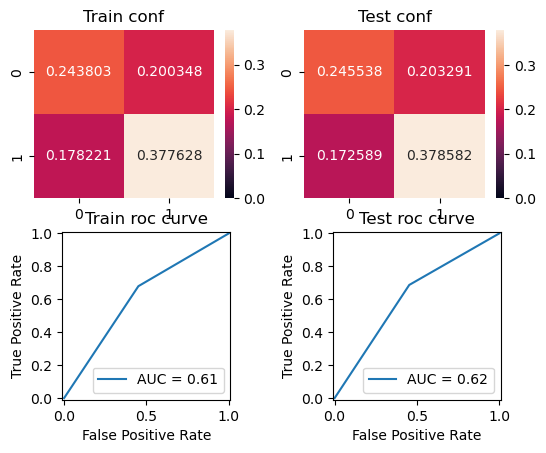

In [27]:
model = OneRClassifier()
feature_list = lable_encoded_cat_features + one_rule_features
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
pred_test = model.predict(test[feature_list].values)

metrics(
    model,
    train[feature_list],
    pred_train,
    pred_train,
    train["target"],
    test[feature_list],
    pred_test,
    pred_test,
    test["target"],
)


## Logistic regression

Accurcy             : Train - 0.828 Test - 0.827
F1 score            : Train - 0.843 Test - 0.841
Roc Auc score       : Train - 0.890 Test - 0.889


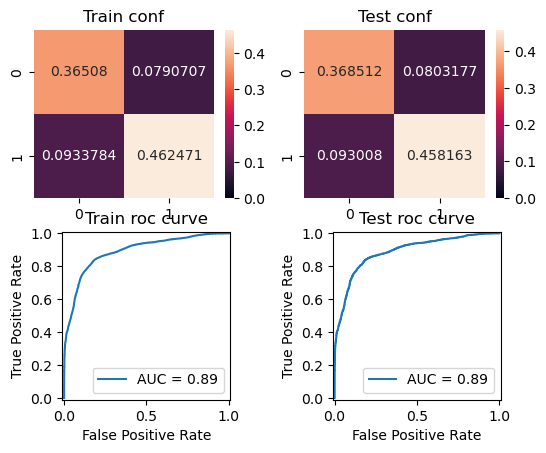

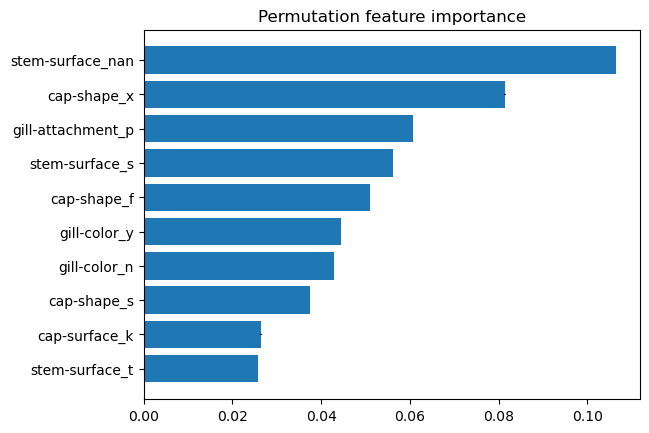

Selected feats:
"stem-surface_nan",
"cap-shape_x",
"gill-attachment_p",
"stem-surface_s",
"cap-shape_f",
"gill-color_y",
"gill-color_n",
"cap-shape_s",
"cap-surface_k",
"stem-surface_t"


In [28]:
feature_list = default_ohe_features
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.667 Test - 0.669
F1 score            : Train - 0.725 Test - 0.726
Roc Auc score       : Train - 0.735 Test - 0.736


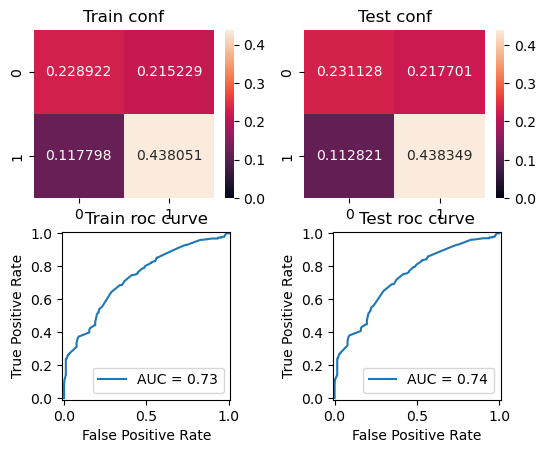

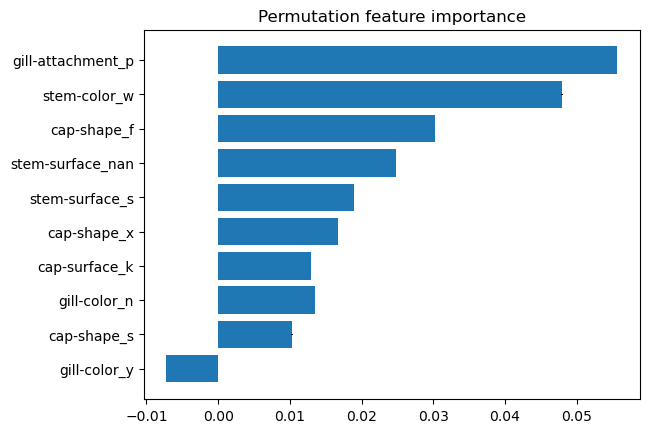

Selected feats:
"gill-attachment_p",
"stem-color_w",
"cap-shape_f",
"stem-surface_nan",
"stem-surface_s",
"cap-shape_x",
"cap-surface_k",
"gill-color_n",
"cap-shape_s",
"gill-color_y"


In [29]:
feature_list = [
    "stem-surface_nan",
    "cap-shape_x",
    "gill-attachment_p",
    "stem-surface_s",
    "cap-shape_f",
    "gill-color_y",
    "gill-color_n",
    "cap-shape_s",
    "stem-color_w",
    "cap-surface_k",
]
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.827 Test - 0.825
F1 score            : Train - 0.842 Test - 0.839
Roc Auc score       : Train - 0.889 Test - 0.888


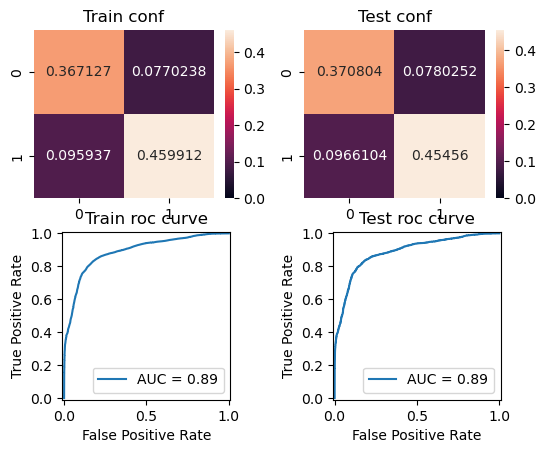

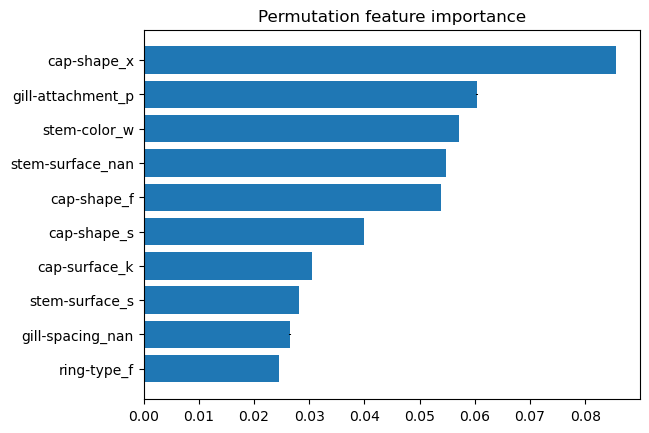

Selected feats:
"cap-shape_x",
"gill-attachment_p",
"stem-color_w",
"stem-surface_nan",
"cap-shape_f",
"cap-shape_s",
"cap-surface_k",
"stem-surface_s",
"gill-spacing_nan",
"ring-type_f"


In [30]:
feature_list = linear_svc_based_features
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


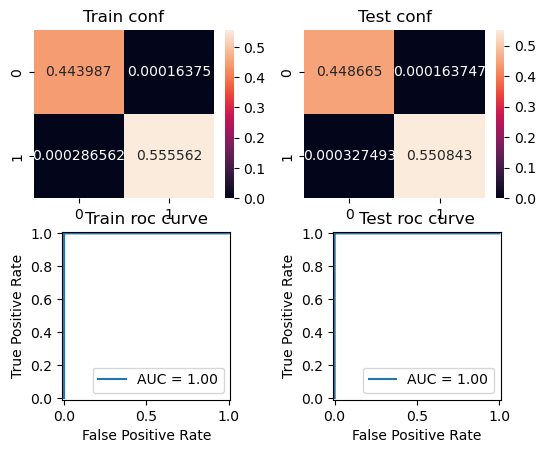

In [32]:
feature_list = default_ohe_features
model = KNeighborsClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
    get_feature_importance=False,
)

Accurcy             : Train - 1.000 Test - 0.999
F1 score            : Train - 1.000 Test - 0.999
Roc Auc score       : Train - 1.000 Test - 1.000


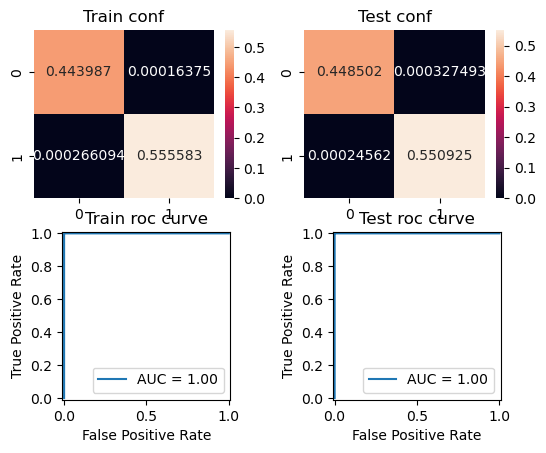

In [33]:
feature_list = linear_svc_based_features
model = KNeighborsClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
    get_feature_importance=False,
)

## Naive baies

In [34]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

Accurcy             : Train - 0.744 Test - 0.743
F1 score            : Train - 0.763 Test - 0.761
Roc Auc score       : Train - 0.823 Test - 0.820


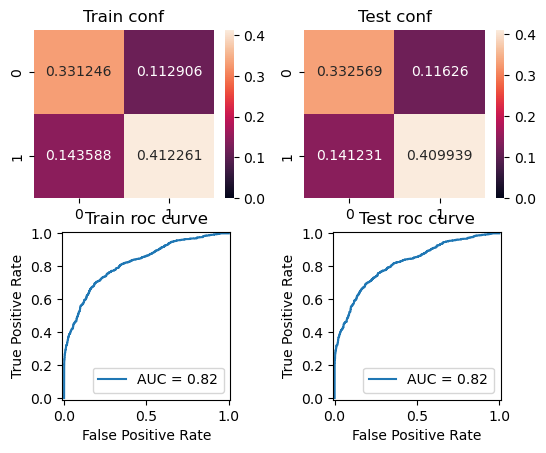

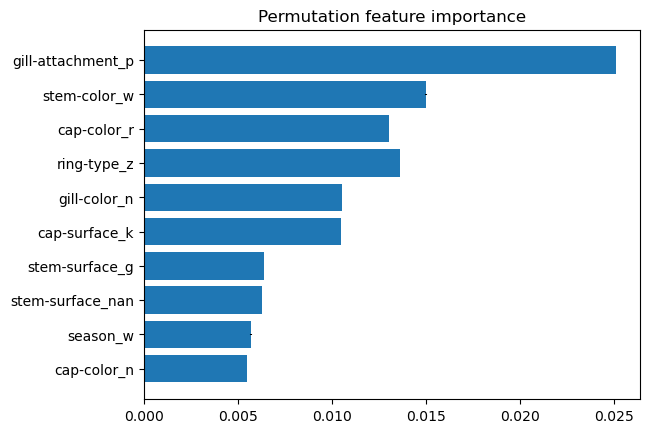

Selected feats:
"gill-attachment_p",
"stem-color_w",
"cap-color_r",
"ring-type_z",
"gill-color_n",
"cap-surface_k",
"stem-surface_g",
"stem-surface_nan",
"season_w",
"cap-color_n"


In [35]:
feature_list = ohe_columns_name
model = BernoulliNB()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.570 Test - 0.570
F1 score            : Train - 0.681 Test - 0.682
Roc Auc score       : Train - 0.577 Test - 0.581


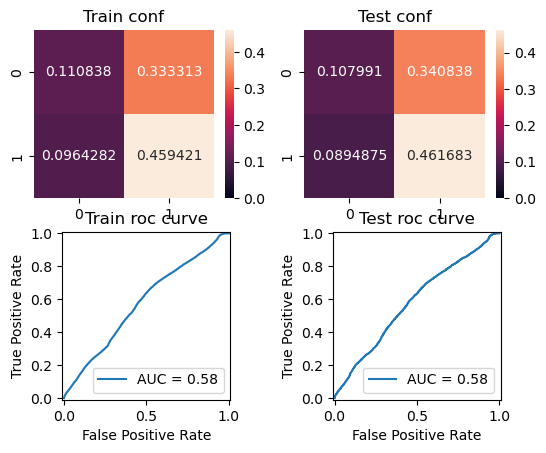

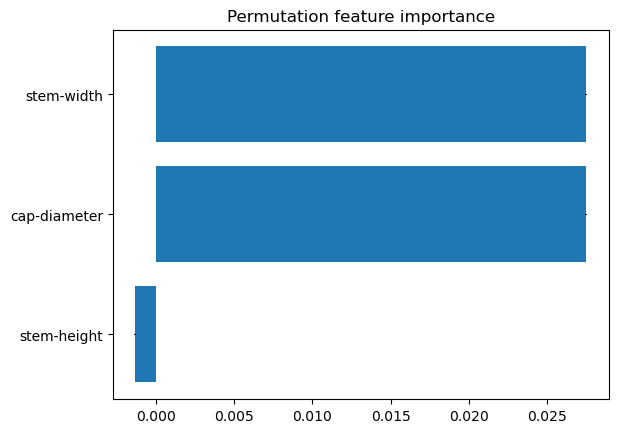

Selected feats:
"stem-width",
"cap-diameter",
"stem-height"


In [36]:
feature_list = real_features
model = GaussianNB()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## Desicion tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

Accurcy             : Train - 0.982 Test - 0.979
F1 score            : Train - 0.984 Test - 0.981
Roc Auc score       : Train - 0.998 Test - 0.997


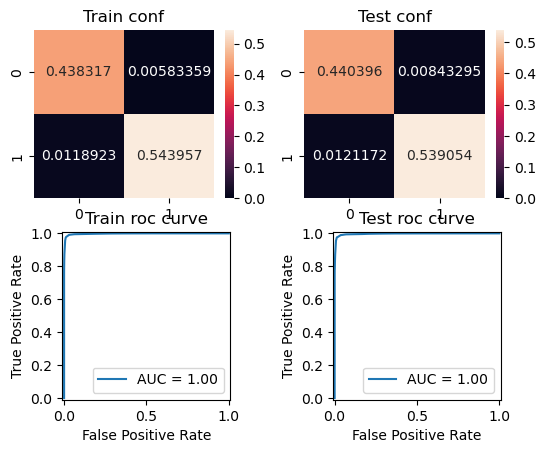

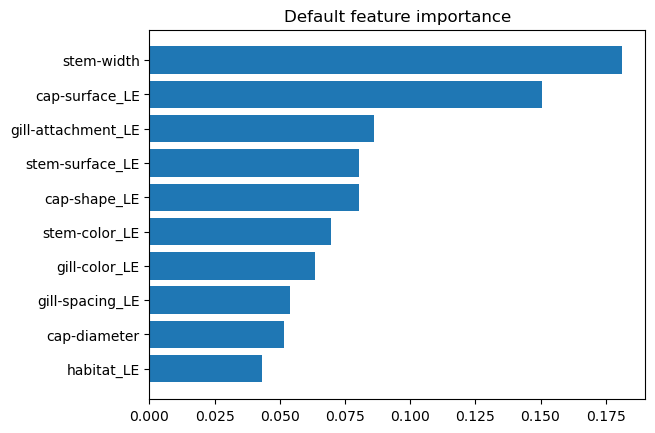

Selected feats:
"stem-width",
"cap-surface_LE",
"gill-attachment_LE",
"stem-surface_LE",
"cap-shape_LE",
"stem-color_LE",
"gill-color_LE",
"gill-spacing_LE",
"cap-diameter",
"habitat_LE"


In [38]:
feature_list = default_le_features
model = DecisionTreeClassifier(max_depth=10)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.889 Test - 0.890
F1 score            : Train - 0.904 Test - 0.903
Roc Auc score       : Train - 0.968 Test - 0.968


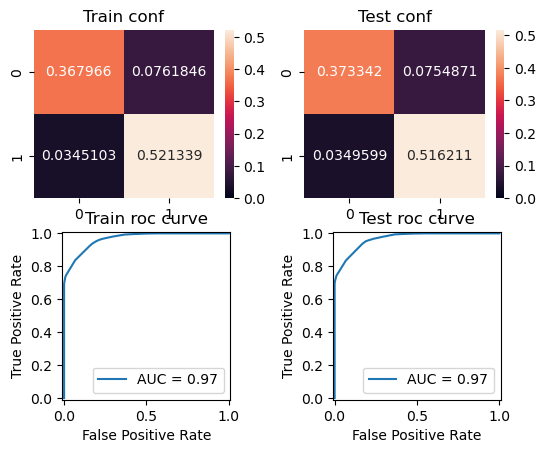

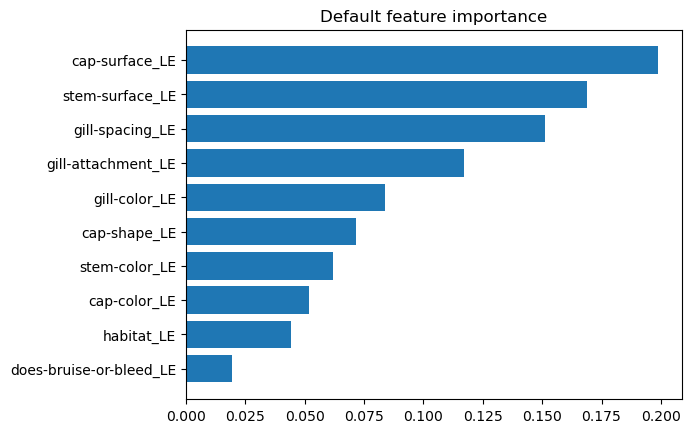

Selected feats:
"cap-surface_LE",
"stem-surface_LE",
"gill-spacing_LE",
"gill-attachment_LE",
"gill-color_LE",
"cap-shape_LE",
"stem-color_LE",
"cap-color_LE",
"habitat_LE",
"does-bruise-or-bleed_LE"


In [39]:
feature_list = lable_encoded_cat_features
model = DecisionTreeClassifier(max_depth=10)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.866 Test - 0.862
F1 score            : Train - 0.871 Test - 0.866
Roc Auc score       : Train - 0.945 Test - 0.942


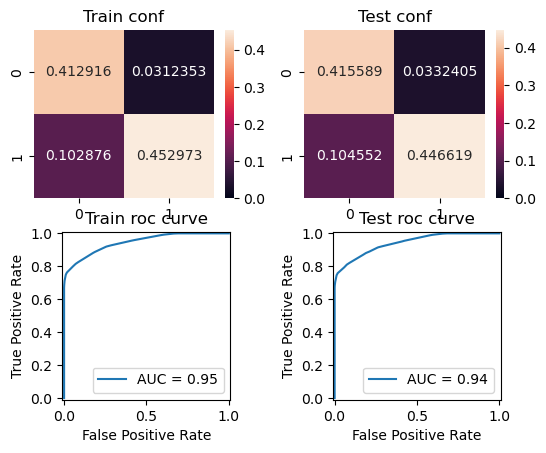

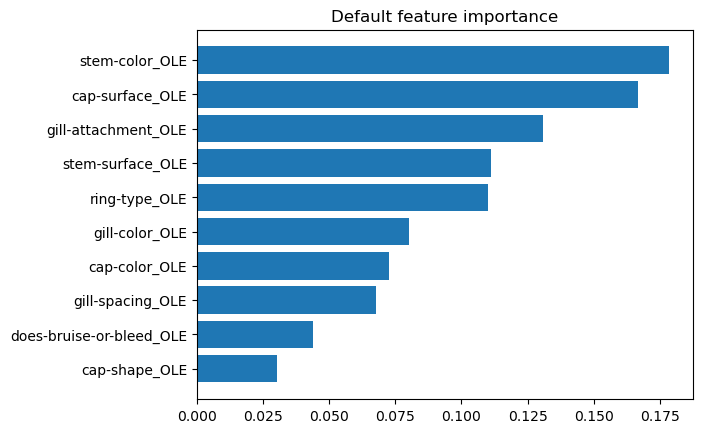

Selected feats:
"stem-color_OLE",
"cap-surface_OLE",
"gill-attachment_OLE",
"stem-surface_OLE",
"ring-type_OLE",
"gill-color_OLE",
"cap-color_OLE",
"gill-spacing_OLE",
"does-bruise-or-bleed_OLE",
"cap-shape_OLE"


In [40]:
feature_list = ordere_lable_encoded_cat_features
model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.911 Test - 0.910
F1 score            : Train - 0.921 Test - 0.919
Roc Auc score       : Train - 0.978 Test - 0.976


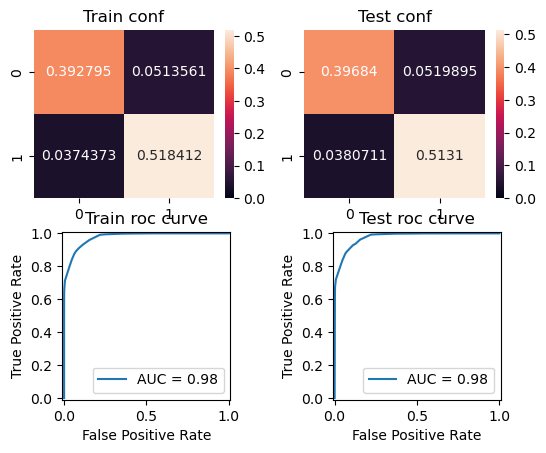

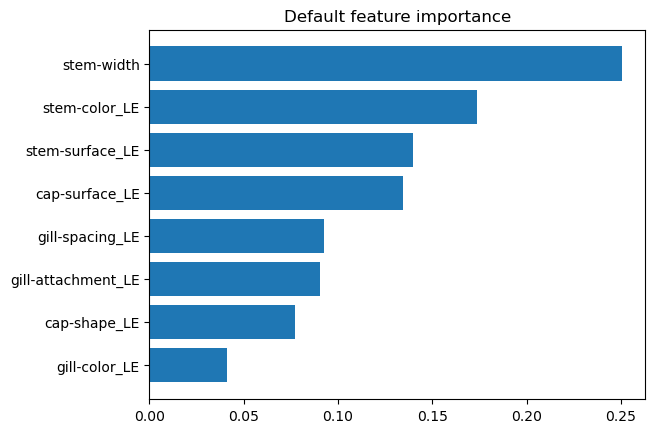

Selected feats:
"stem-width",
"stem-color_LE",
"stem-surface_LE",
"cap-surface_LE",
"gill-spacing_LE",
"gill-attachment_LE",
"cap-shape_LE",
"gill-color_LE"


In [41]:
feature_list = tree_based_features
model = DecisionTreeClassifier(max_depth=8)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## Boosting

In [42]:
from catboost import CatBoostClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


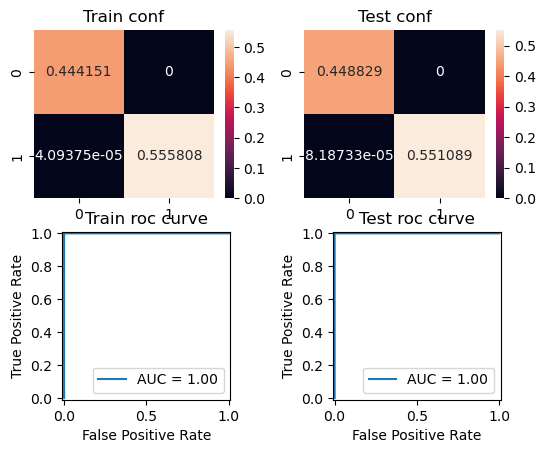

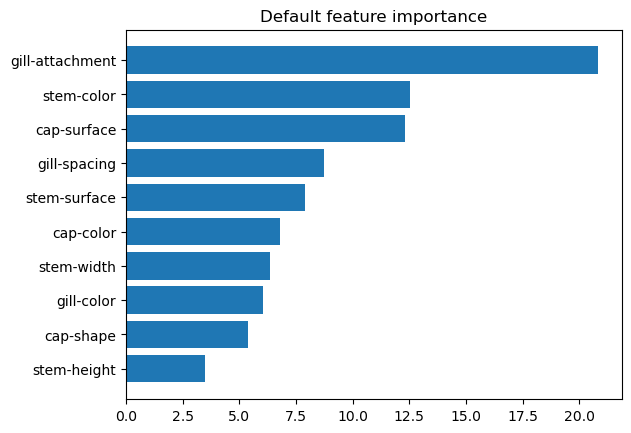

Selected feats:
"gill-attachment",
"stem-color",
"cap-surface",
"gill-spacing",
"stem-surface",
"cap-color",
"stem-width",
"gill-color",
"cap-shape",
"stem-height"


In [43]:
feature_list = real_features + cat_features
catboost_features = list(set(cat_features) & set(feature_list))

t_df = train[feature_list + ["target"]]
test_df = test[feature_list + ["target"]]

t_df.loc[:, catboost_features] = t_df[catboost_features].astype(str)
test_df.loc[:, catboost_features] = test_df[catboost_features].astype(str)

model = CatBoostClassifier(cat_features=catboost_features)
model.fit(t_df[feature_list], t_df["target"].values, silent=True)

pred_train = model.predict(t_df[feature_list])
proba_train = model.predict_proba(t_df[feature_list])[:, 1]
pred_test = model.predict(test_df[feature_list])
proba_test = model.predict_proba(test_df[feature_list])[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.999 Test - 0.999
F1 score            : Train - 0.999 Test - 0.999
Roc Auc score       : Train - 1.000 Test - 1.000


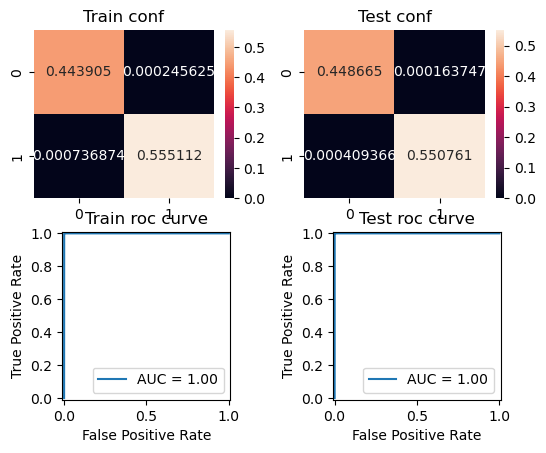

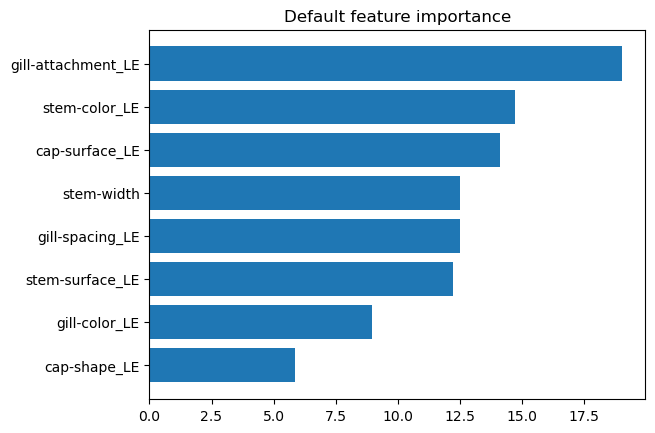

Selected feats:
"gill-attachment_LE",
"stem-color_LE",
"cap-surface_LE",
"stem-width",
"gill-spacing_LE",
"stem-surface_LE",
"gill-color_LE",
"cap-shape_LE"


In [44]:
feature_list = list(tree_based_features)
catboost_features = list(set(tree_based_features) & set(lable_encoded_cat_features))
t_df = train[feature_list + ["target"]]
test_df = test[feature_list + ["target"]]
t_df.loc[:, catboost_features] = t_df[catboost_features].astype(int)
test_df.loc[:, catboost_features] = test_df[catboost_features].astype(int)
model = CatBoostClassifier(cat_features=catboost_features)
model.fit(t_df[feature_list], t_df["target"].values, silent=True)
pred_train = model.predict(t_df[feature_list])
proba_train = model.predict_proba(t_df[feature_list])[:, 1]
pred_test = model.predict(test_df[feature_list])
proba_test = model.predict_proba(test_df[feature_list])[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## SVC

In [45]:
from sklearn.svm import LinearSVC

from sklearn.calibration import CalibratedClassifierCV


Accurcy             : Train - 0.827 Test - 0.827
F1 score            : Train - 0.843 Test - 0.841
Roc Auc score       : Train - 0.889 Test - 0.888


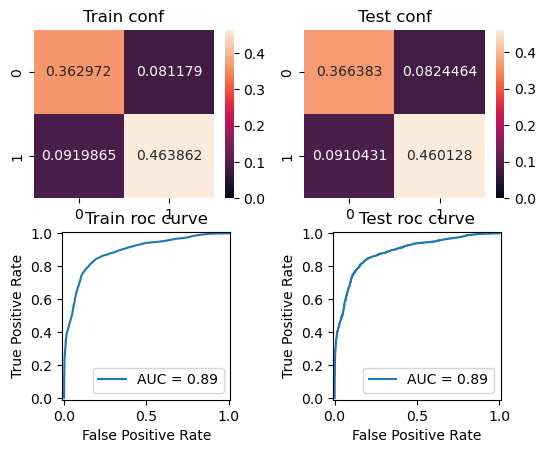

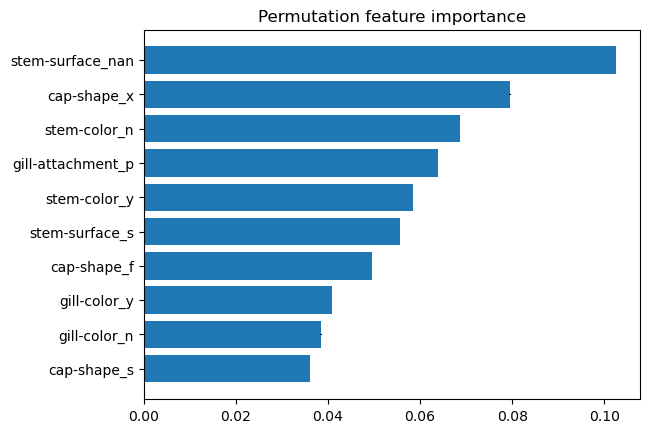

Selected feats:
"stem-surface_nan",
"cap-shape_x",
"stem-color_n",
"gill-attachment_p",
"stem-color_y",
"stem-surface_s",
"cap-shape_f",
"gill-color_y",
"gill-color_n",
"cap-shape_s"


In [46]:
feature_list = default_ohe_features

model = CalibratedClassifierCV(LinearSVC(dual="auto"))
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.827 Test - 0.827
F1 score            : Train - 0.843 Test - 0.841
Roc Auc score       : Train - 0.889 Test - 0.888


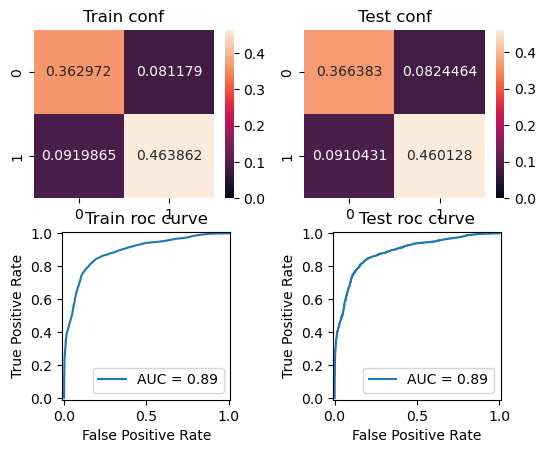

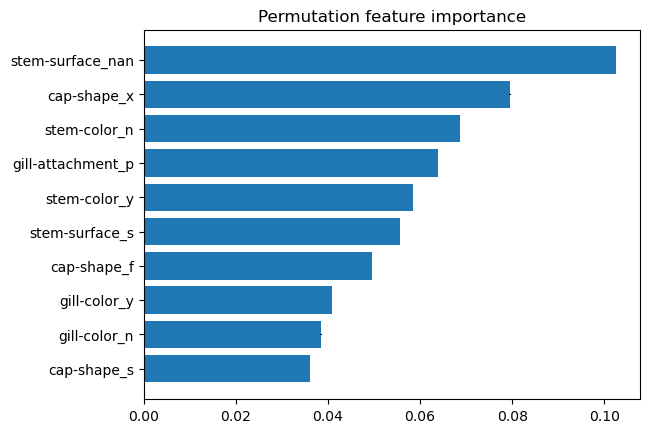

Selected feats:
"stem-surface_nan",
"cap-shape_x",
"stem-color_n",
"gill-attachment_p",
"stem-color_y",
"stem-surface_s",
"cap-shape_f",
"gill-color_y",
"gill-color_n",
"cap-shape_s"


In [47]:
feature_list = default_ohe_features

model = CalibratedClassifierCV(LinearSVC(dual="auto"), cv=5)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.828 Test - 0.826
F1 score            : Train - 0.843 Test - 0.840
Roc Auc score       : Train - 0.888 Test - 0.886


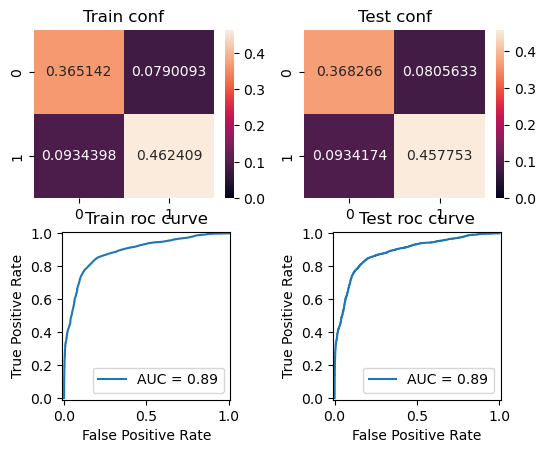

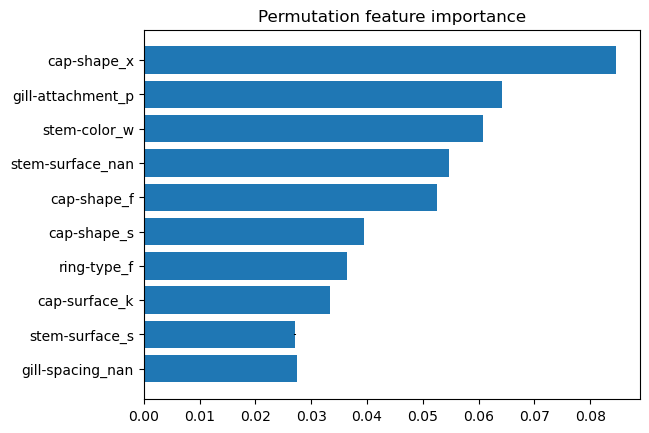

Selected feats:
"cap-shape_x",
"gill-attachment_p",
"stem-color_w",
"stem-surface_nan",
"cap-shape_f",
"cap-shape_s",
"ring-type_f",
"cap-surface_k",
"stem-surface_s",
"gill-spacing_nan"


In [48]:
feature_list = linear_svc_based_features

model = CalibratedClassifierCV(LinearSVC(dual="auto"))
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## MLP

In [49]:
from sklearn.neural_network import MLPClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


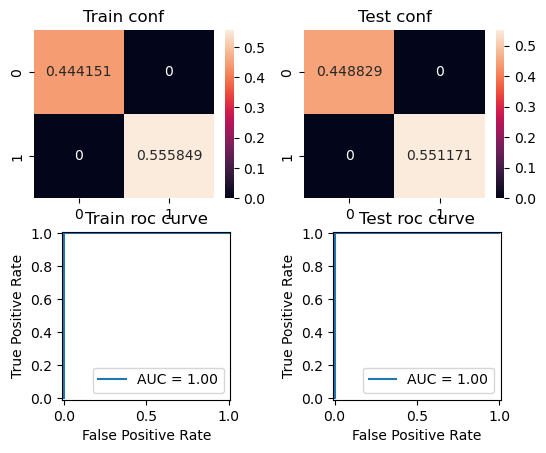

In [50]:
feature_list = default_ohe_features

model = MLPClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
    get_feature_importance=False,
)

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


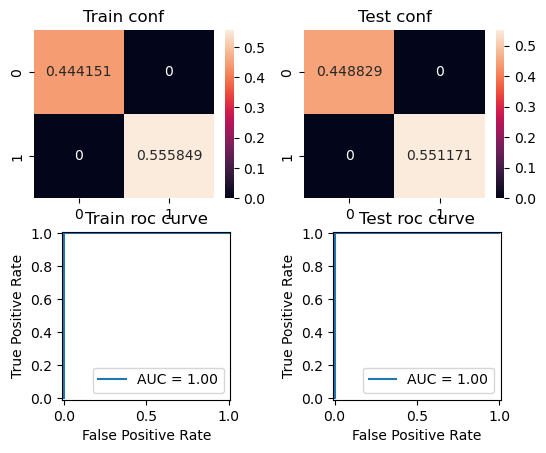

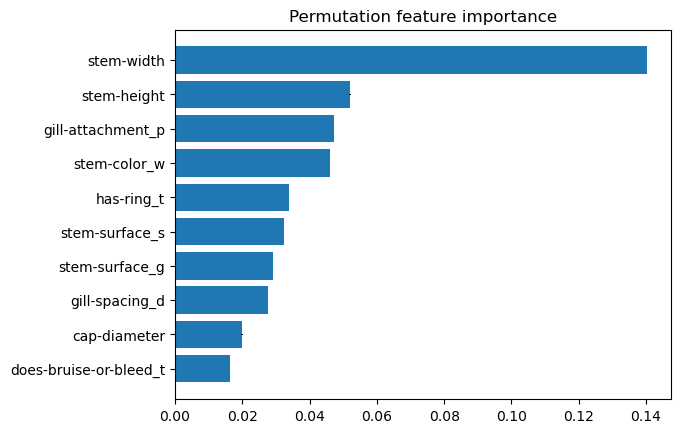

Selected feats:
"stem-width",
"stem-height",
"gill-attachment_p",
"stem-color_w",
"has-ring_t",
"stem-surface_s",
"stem-surface_g",
"gill-spacing_d",
"cap-diameter",
"does-bruise-or-bleed_t"


In [68]:
feature_list = linear_svc_based_features

model = MLPClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## Ensamble

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

Accurcy             : Train - 0.926 Test - 0.923
F1 score            : Train - 0.934 Test - 0.931
Roc Auc score       : Train - 0.981 Test - 0.981


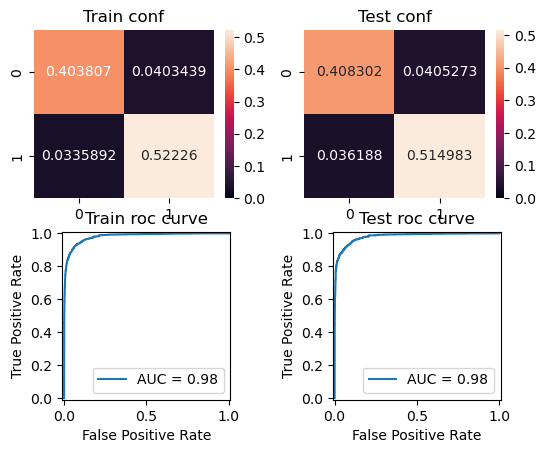

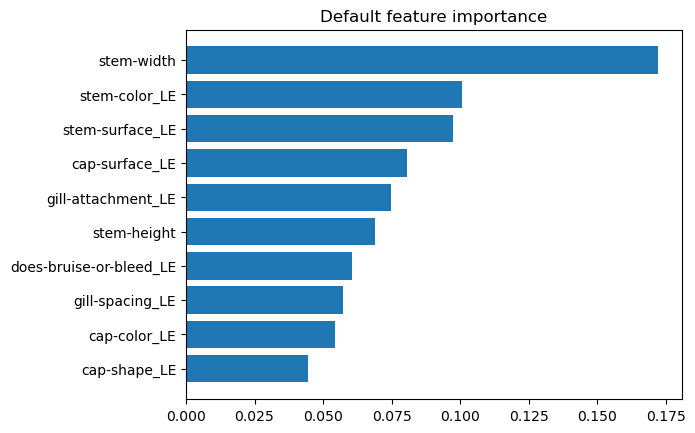

Selected feats:
"stem-width",
"stem-color_LE",
"stem-surface_LE",
"cap-surface_LE",
"gill-attachment_LE",
"stem-height",
"does-bruise-or-bleed_LE",
"gill-spacing_LE",
"cap-color_LE",
"cap-shape_LE"


In [53]:
feature_list = default_le_features

model = GradientBoostingClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

In [54]:
from sklearn.ensemble import RandomForestClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


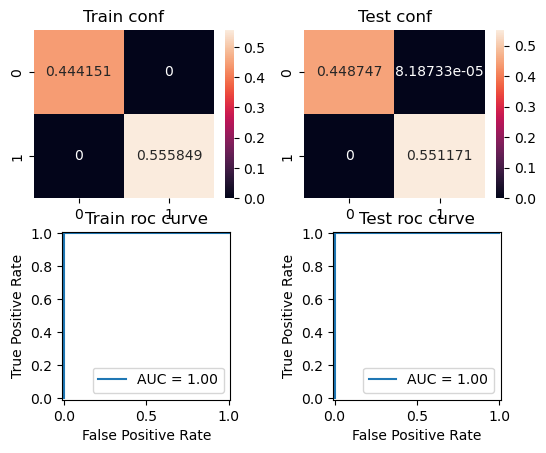

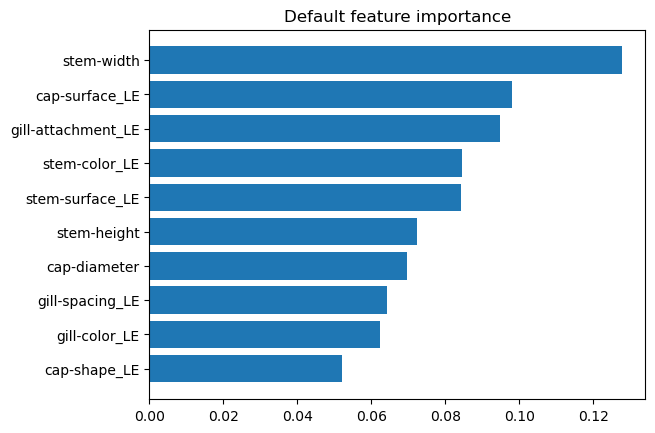

Selected feats:
"stem-width",
"cap-surface_LE",
"gill-attachment_LE",
"stem-color_LE",
"stem-surface_LE",
"stem-height",
"cap-diameter",
"gill-spacing_LE",
"gill-color_LE",
"cap-shape_LE"


In [55]:
feature_list = default_le_features

model = RandomForestClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
)

## Супер дупер классификатор
Интуиция за работой алгоритма:
Греки решили сдать экзамен, разделили билеты между друг другом, каждый взял свой билет и $examples\_per\_estimator$ случайных, рядом лежащих. Уже на экзамене все греки получили билет и начали искать того самого который точно учил такой билет

* Выбирается $n$ случайных объектов из выборки
* Выбрается $\bar{n}$ объектов (предположим $\bar{n} < n$)
* Считается среднее и std для каждой фичи и строится моедль логистической регрессии
* Через среднее и дисперсию признаков считается увереность модели в предсказании
* Строится много таких моделей


In [56]:
class GreekAgent:
    def __init__(self, model_type, max_conf):
        self.model_type = model_type
        self.max_conf = max_conf

    def fit(self, X, y):
        self.means = X.mean(axis=0)
        self.std = X.std(axis=0)

        self.model = self.model_type().fit(X, y)

        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X)[:, 1]
        return self.model.predict(X)

    def confidence(self, X):
        dist = np.abs(X - self.means) / self.std  # z|t оценка, я не помню
        return np.minimum(1 / (dist.mean(axis=-1) + 1e-10), self.max_conf)

    def confidence_pred(self, X):
        return np.maximum(self.confidence(X), 0.1)


class SupaDupaEnsamble(BaseEstimator):
    def __init__(
        self,
        model_type,
        n_estimator=50,
        examples_per_estimator=None,
        seed=42,
        max_conf=10,
    ):
        self.model_type = model_type
        self.n_estimator = n_estimator
        self.examples_per_estimator = examples_per_estimator
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        self.max_conf = max_conf

    def fit(self, X, y, show_plot=False):
        if self.examples_per_estimator is None:
            self.examples_per_estimator = int(len(X) / self.n_estimator * 2)

        inds = self.rng.choice(np.arange(len(X)), len(X), replace=False)

        X = X[inds]
        y = y[inds]

        self.scaler = StandardScaler().fit(X)
        X = self.scaler.transform(X)

        self.models = []

        for i in range(self.n_estimator):
            default_dist = np.ones(len(X))
            for model in self.models:
                default_dist += model.confidence(X)

            default_dist = default_dist.sum() - default_dist
            if show_plot:
                plt.title(f"Confidense in data at step {i}")
                plt.scatter(X, y, c=default_dist)
                plt.colorbar()
                plt.show()
            selected = np.random.choice(
                np.arange(len(X)), 1, p=default_dist / default_dist.sum()
            )[0]

            dist = np.linalg.norm(X - X[selected], axis=-1)
            dist = np.exp(1 - dist / dist.sum())
            closes_inds = np.argsort(dist)[-self.examples_per_estimator * 2 :]
            subset_inds = self.rng.choice(
                np.arange(len(closes_inds)),
                self.examples_per_estimator,
                replace=False,
                p=dist[closes_inds] / dist[closes_inds].sum(),
            )
            if show_plot:
                plt.scatter(X, y, c=dist)
                plt.title(f"Selected data at step {i}")
                plt.colorbar()
                plt.scatter(
                    X[closes_inds], y[closes_inds], c="green", label="closes_points"
                )
                plt.scatter(
                    X[closes_inds][subset_inds],
                    y[closes_inds][subset_inds],
                    c="blue",
                    label="selected_points",
                )
                plt.scatter([X[selected]], [y[selected]], c="red", label="Centroid")
                plt.legend()
                plt.show()

            self.models.append(
                GreekAgent(self.model_type, self.max_conf).fit(
                    X[closes_inds][subset_inds], y[closes_inds][subset_inds]
                )
            )

        return self

    def show_final_plot(self, X, y):
        X = self.scaler.transform(X)
        plt.title("Greeks placement")
        plt.scatter(X[:, 0], y, c=y)
        for m in self.models:
            pred = m.predict(X)
            mask = m.confidence(X) > 0.9
            # Clip only for showcase
            plt.scatter(
                X[:, 0][mask],
                pred[mask],
                alpha=m.confidence(X)[mask] / 100,
                label="Part predict with confidence",
                s=4,
            )
        plt.show()

    def predict_proba(self, X):
        X = self.scaler.transform(X)
        pred = np.zeros(len(X))
        confs = np.zeros(len(X))
        for model in self.models:
            conf = model.confidence(X)
            inds = np.argmax(np.c_[confs, conf], axis=-1)
            confs = np.c_[confs, conf][np.arange(len(X)), inds]
            pred = np.c_[pred, model.predict_proba(X)][np.arange(len(X)), inds]

        return pred

    def predict(self, X):
        return self.predict_proba(X) > 0.5

### SupaDupa showcase

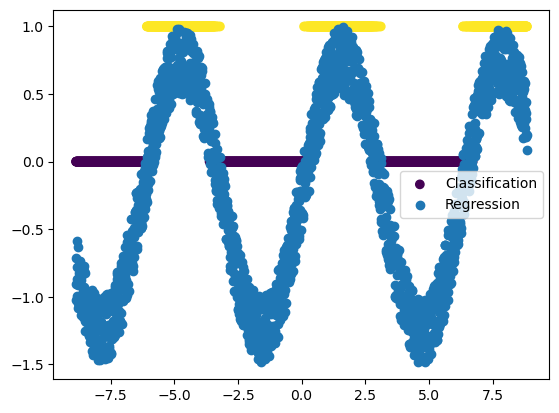

In [57]:
points_count = 2000
inds = (np.arange(points_count) / points_count - 0.5) * np.pi * 5 + (
    np.arange(points_count) / points_count - 0.5
) * 2
X = inds[:, None]
y_reg = np.sin(inds) + np.random.random(points_count) / 2 - 0.5
y_cls = y_reg > 0
plt.scatter(X[:, 0], y_cls, c=y_cls, label="Classification")
plt.scatter(X[:, 0], y_reg, label="Regression")
plt.legend()
plt.show()

#### EnsemblePart

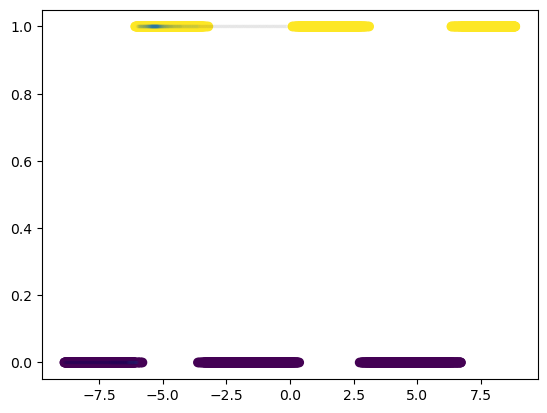

In [58]:
part = GreekAgent(LogisticRegression, 10).fit(X[200:600], y_cls[200:600])
pred = part.predict(X)
plt.scatter(X[:, 0], y_cls, c=y_cls)
# Clip only for showcase
plt.scatter(
    X[:, 0],
    pred,
    alpha=part.confidence_pred(X) / 100,
    label="Part predict with confidence",
    s=4,
)
plt.show()

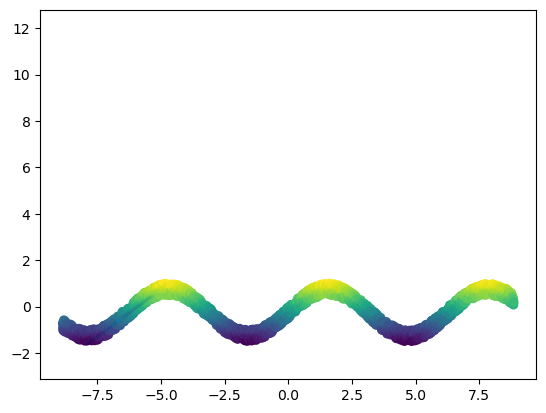

In [59]:
part = GreekAgent(LinearRegression, 10).fit(X[200:300], y_reg[200:300])
pred = part.predict(X)
plt.scatter(X[:, 0], y_reg, c=y_reg)
# Clip only for showcase
plt.scatter(
    X[:, 0],
    pred,
    alpha=part.confidence_pred(X)/100,
    label="Part predict with confidence",
    s=4
)
plt.show()

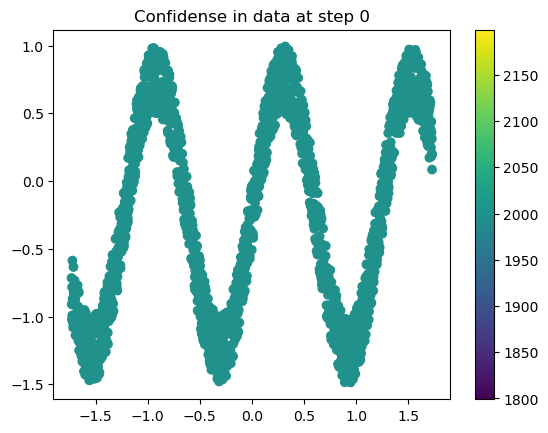

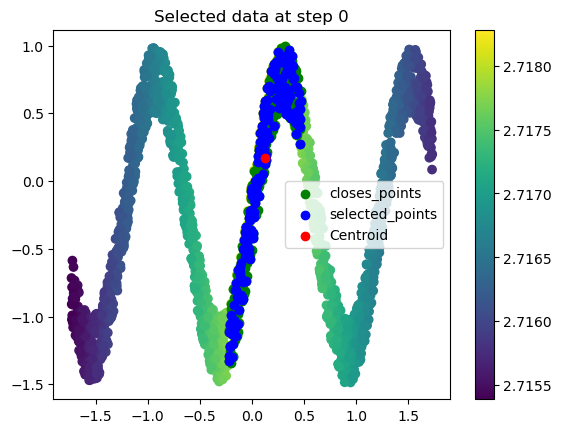

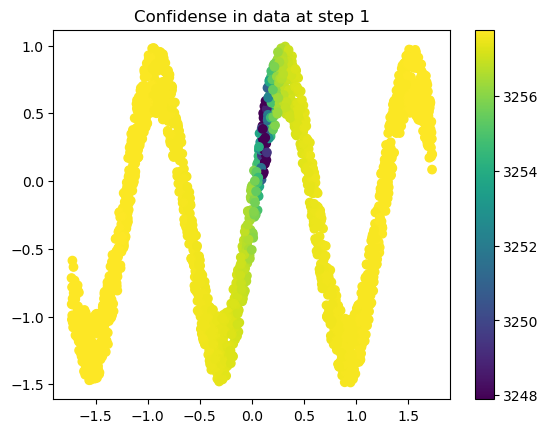

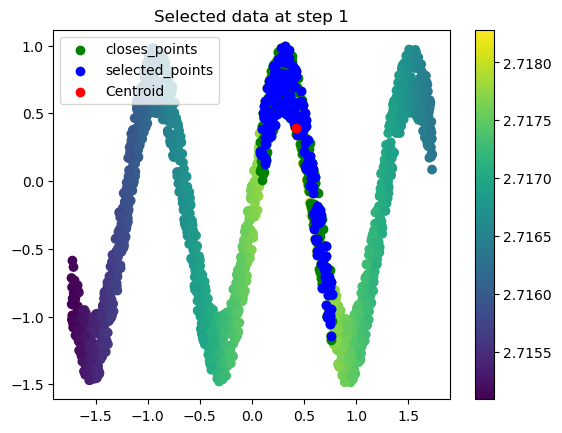

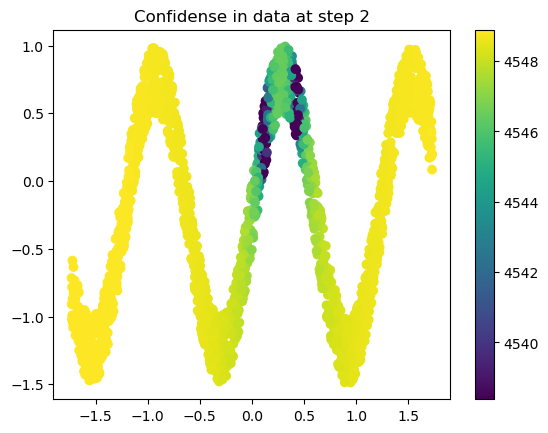

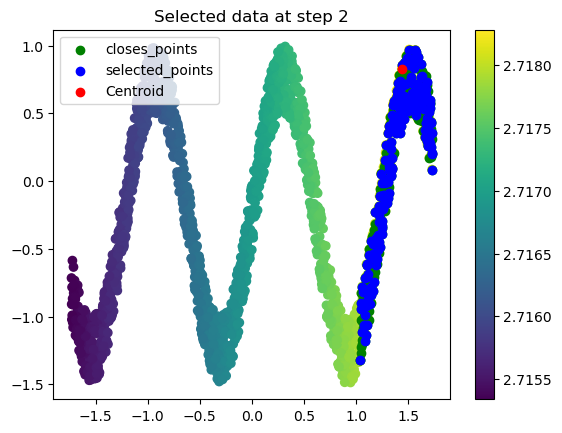

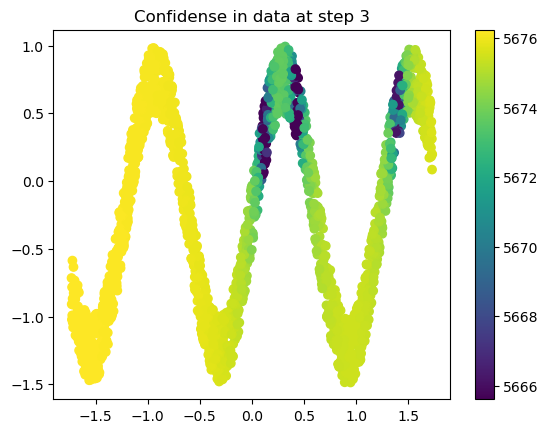

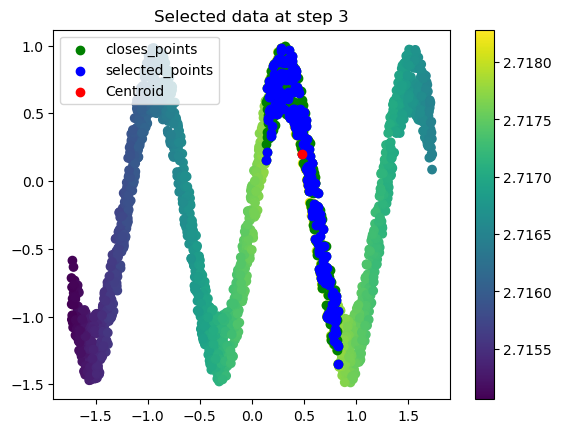

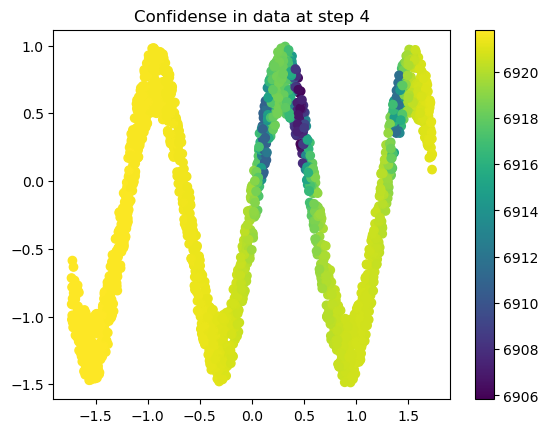

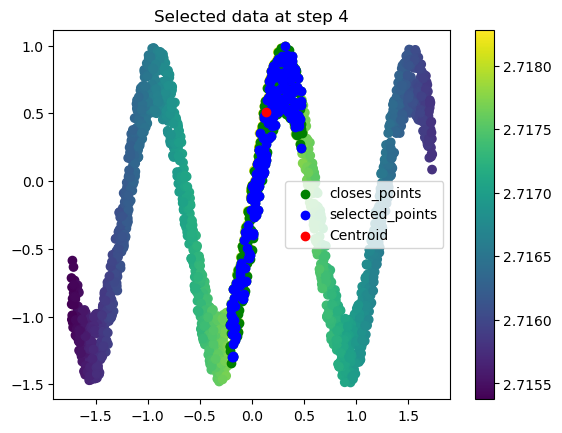

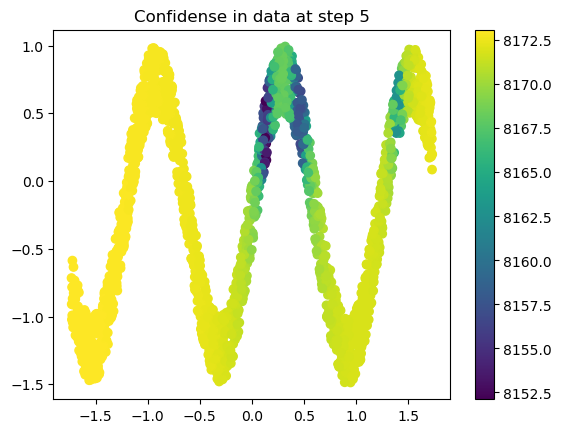

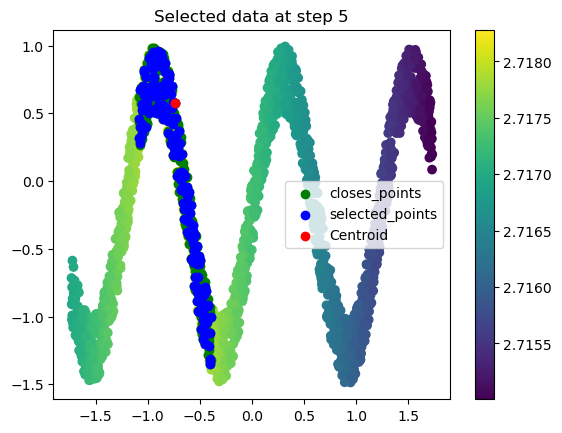

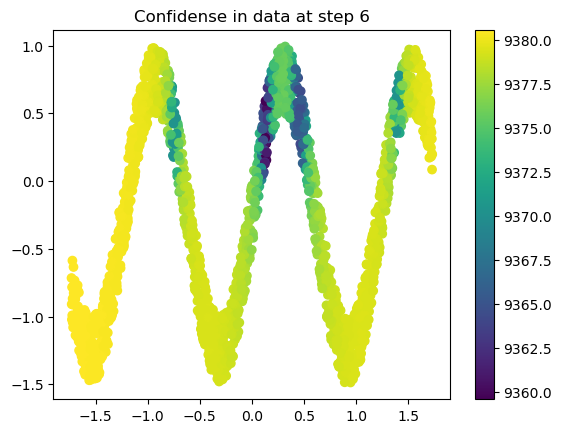

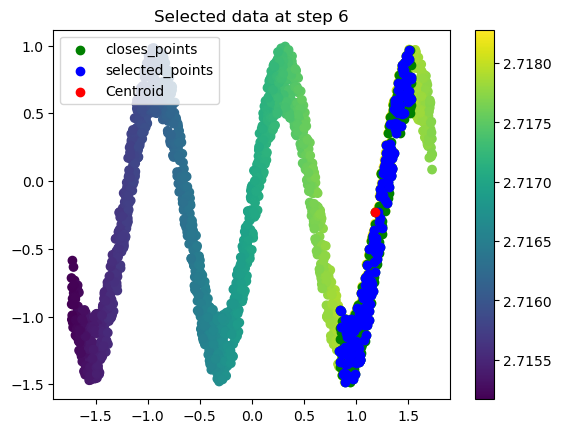

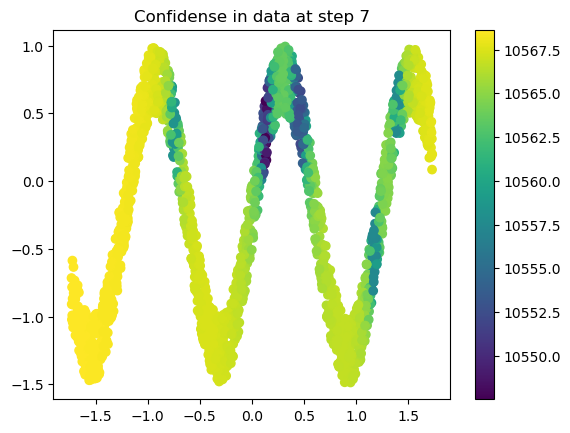

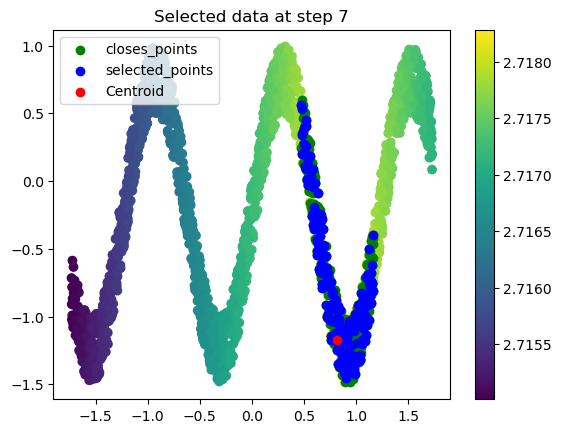

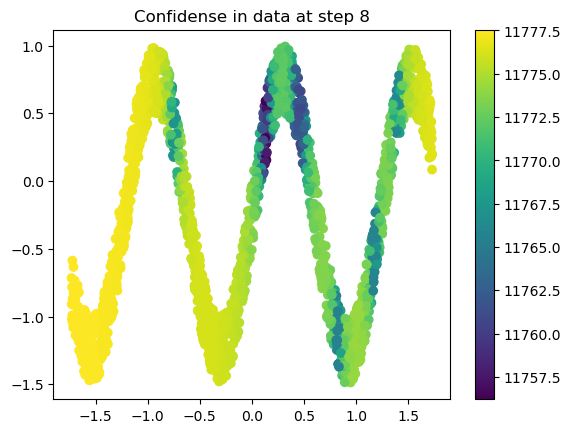

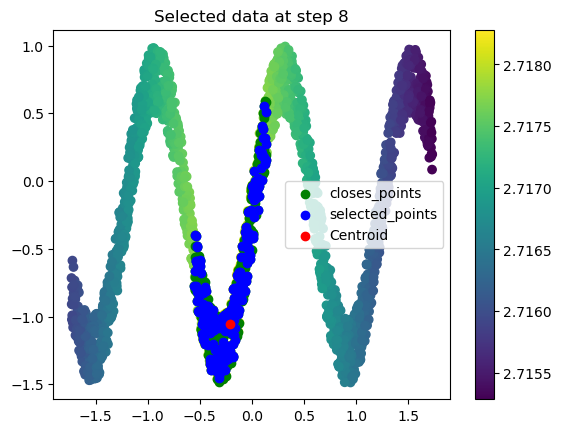

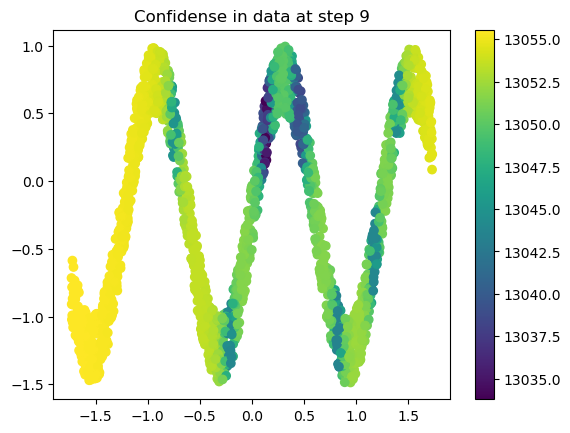

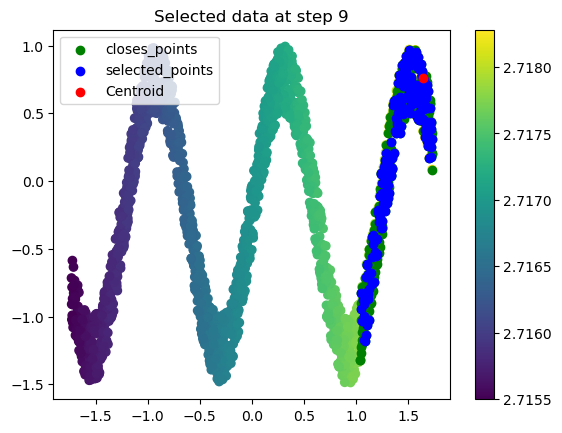

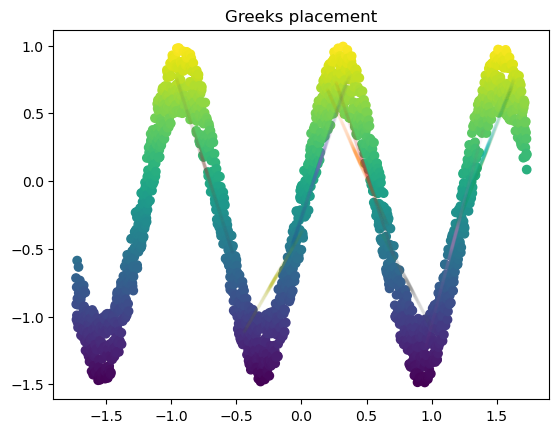

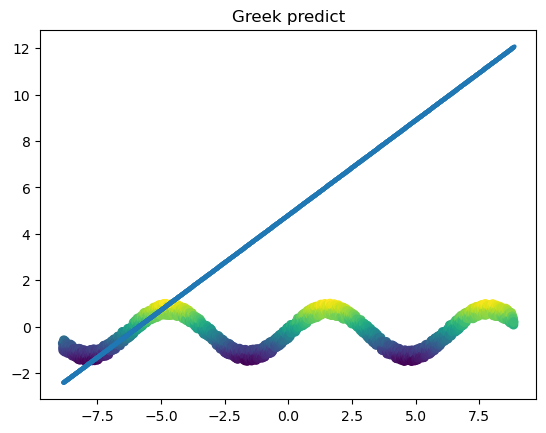

In [60]:
# Learning example
model = SupaDupaEnsamble(
    LinearRegression, n_estimator=10, examples_per_estimator=200, seed=50
)
model.fit(X, y_reg, show_plot=True)
model.show_final_plot(X, y_reg)

pred = part.predict_proba(X)
plt.scatter(X[:, 0], y_reg, c=y_reg)
plt.title("Greek predict")

plt.scatter(
    X[:, 0],
    pred,
    label="Part predict with confidence",
    s=4,
)
plt.show()

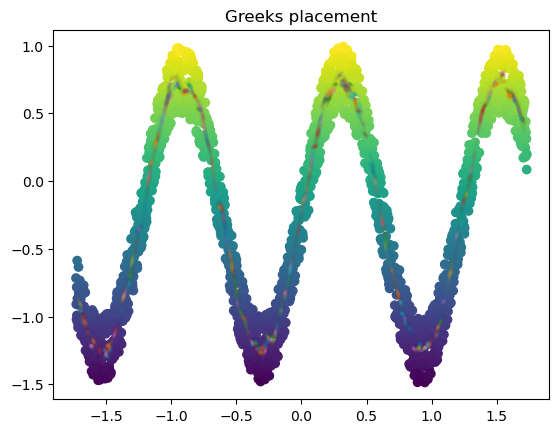

In [61]:
model = SupaDupaEnsamble(LinearRegression, n_estimator=300, examples_per_estimator=20, seed=50)
model.fit(X, y_reg)
model.show_final_plot(X, y_reg)

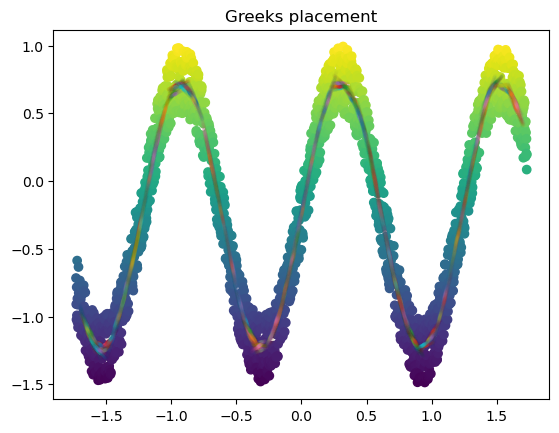

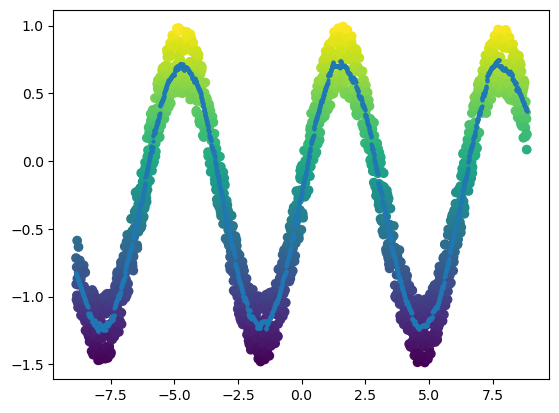

In [62]:
part = SupaDupaEnsamble(
    LinearRegression, n_estimator=300, examples_per_estimator=50
).fit(X, y_reg)
part.show_final_plot(X, y_reg)
pred = part.predict_proba(X)
plt.scatter(X[:, 0], y_reg, c=y_reg)
plt.scatter(
    X[:, 0],
    pred,
    label="Part predict with confidence",
    s=4,
)
plt.show()

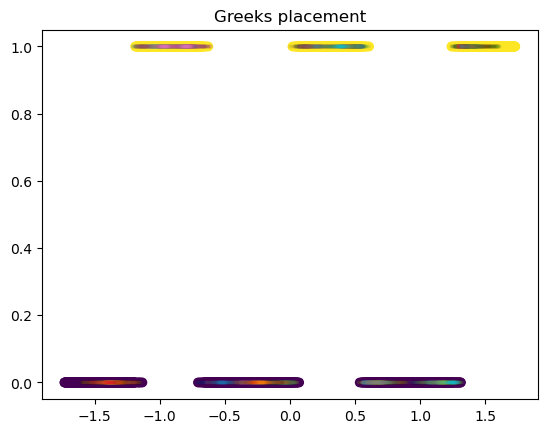

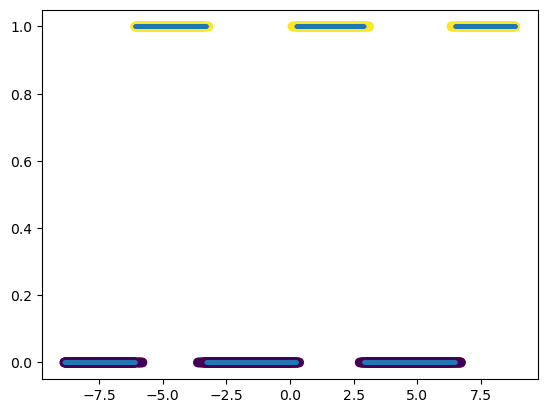

In [63]:
part = SupaDupaEnsamble(
    LogisticRegression, n_estimator=50, examples_per_estimator=200
).fit(X, y_cls)
pred = part.predict(X)
part.show_final_plot(X, y_cls)
plt.scatter(X[:, 0], y_cls, c=y_cls)
# Clip only for showcase
plt.scatter(
    X[:, 0],
    pred,
    label="Part predict with confidence",
    s=4,
)
plt.show()

Accurcy             : Train - 0.943 Test - 0.940
F1 score            : Train - 0.949 Test - 0.946
Roc Auc score       : Train - 0.966 Test - 0.966


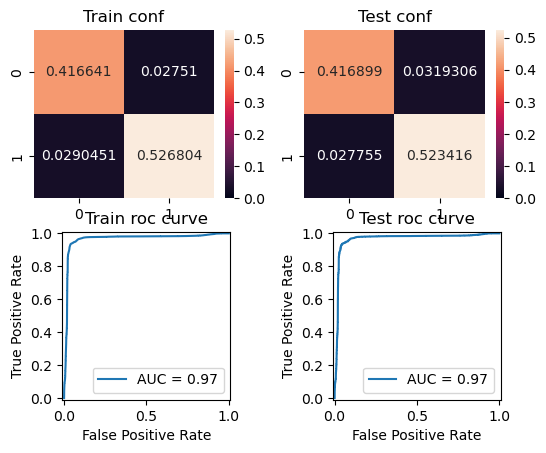

In [65]:
feature_list = default_ohe_features

model = SupaDupaEnsamble(LogisticRegression, n_estimator=100, seed=50)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)

metrics(model,
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    test[feature_list],
    proba_test,
    pred_test,
    test["target"],
    get_feature_importance=False
)